In [1]:
import gc
import os 
import torch
import pickle
import pandas as pd

from data.dataset import ReflacxDataset
from utils.transforms import get_transform
from utils.plot import plot_result, plot_loss, get_legend_elements, disease_cmap
from utils.coco_eval import external_summarize
from models.rcnn import get_model_instance_segmentation, get_multimodal_model_instance_segmentation

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

## [Ajustable Section 1] Define the model you want to use.

In [2]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

use_clinical = False
use_custom_modal = False

## Load dataste.

In [3]:
labels_cols = [
    "Enlarged cardiac silhouette",
    "Atelectasis",
    "Pleural abnormality",
    "Consolidation",
    "Pulmonary edema",
    #  'Groundglass opacity', # 6th disease.
]

dataset_params_dict = {
    "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
    "with_clinical": use_clinical,
    "using_full_reflacx": False,
    "bbox_to_mask": True,
    "labels_cols": labels_cols,
}

detect_eval_dataset = ReflacxDataset(
    **{**dataset_params_dict, "using_full_reflacx": False,},
    transforms=get_transform(train=False),
)

## Check if GPU is available, and clean the memory for GPU.

In [4]:
gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"This notebook will running on device: [{device}]")

if use_gpu:
    torch.cuda.empty_cache()

This notebook will running on device: [cuda]


## Which trained model to load is decided here.

In [5]:
model_path_dict = {
    "custom": {
        "with_clinical": "epoch99_WithClincal_03-11-2022 17-34-14",
        "without_clinical": "epoch99_WithoutClincal_03-11-2022 09-05-17",
    },
    "original": {
        "with_clinical": None,
        "without_clinical": "epoch99_WithoutClincal_03-12-2022 07-56-08",
    },
}


final_model_path = model_path_dict["custom" if use_custom_modal else "original"][
    "with_clinical" if use_clinical else "without_clinical"
]

legend_elements = get_legend_elements(disease_cmap["solid"])


assert not final_model_path is None, "Doesn't have the model yet."


In [6]:
if use_custom_modal:
    model = get_multimodal_model_instance_segmentation(
        len(detect_eval_dataset.labels_cols) + 1, use_clinical=use_clinical,
    )

else:
    model = get_model_instance_segmentation(
        len(detect_eval_dataset.labels_cols) +1,
    )

model.to(device)

model.load_state_dict(
    torch.load(os.path.join("trained_models", final_model_path), map_location=device)
)

model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Load the tarining history to plot the loss curves and evaluation result for the loaded model.

In [7]:
with open(os.path.join("training_records", f"{final_model_path}.pkl"), 'rb') as f:
    training_record = pickle.load(f)

#### Plot loss curves.

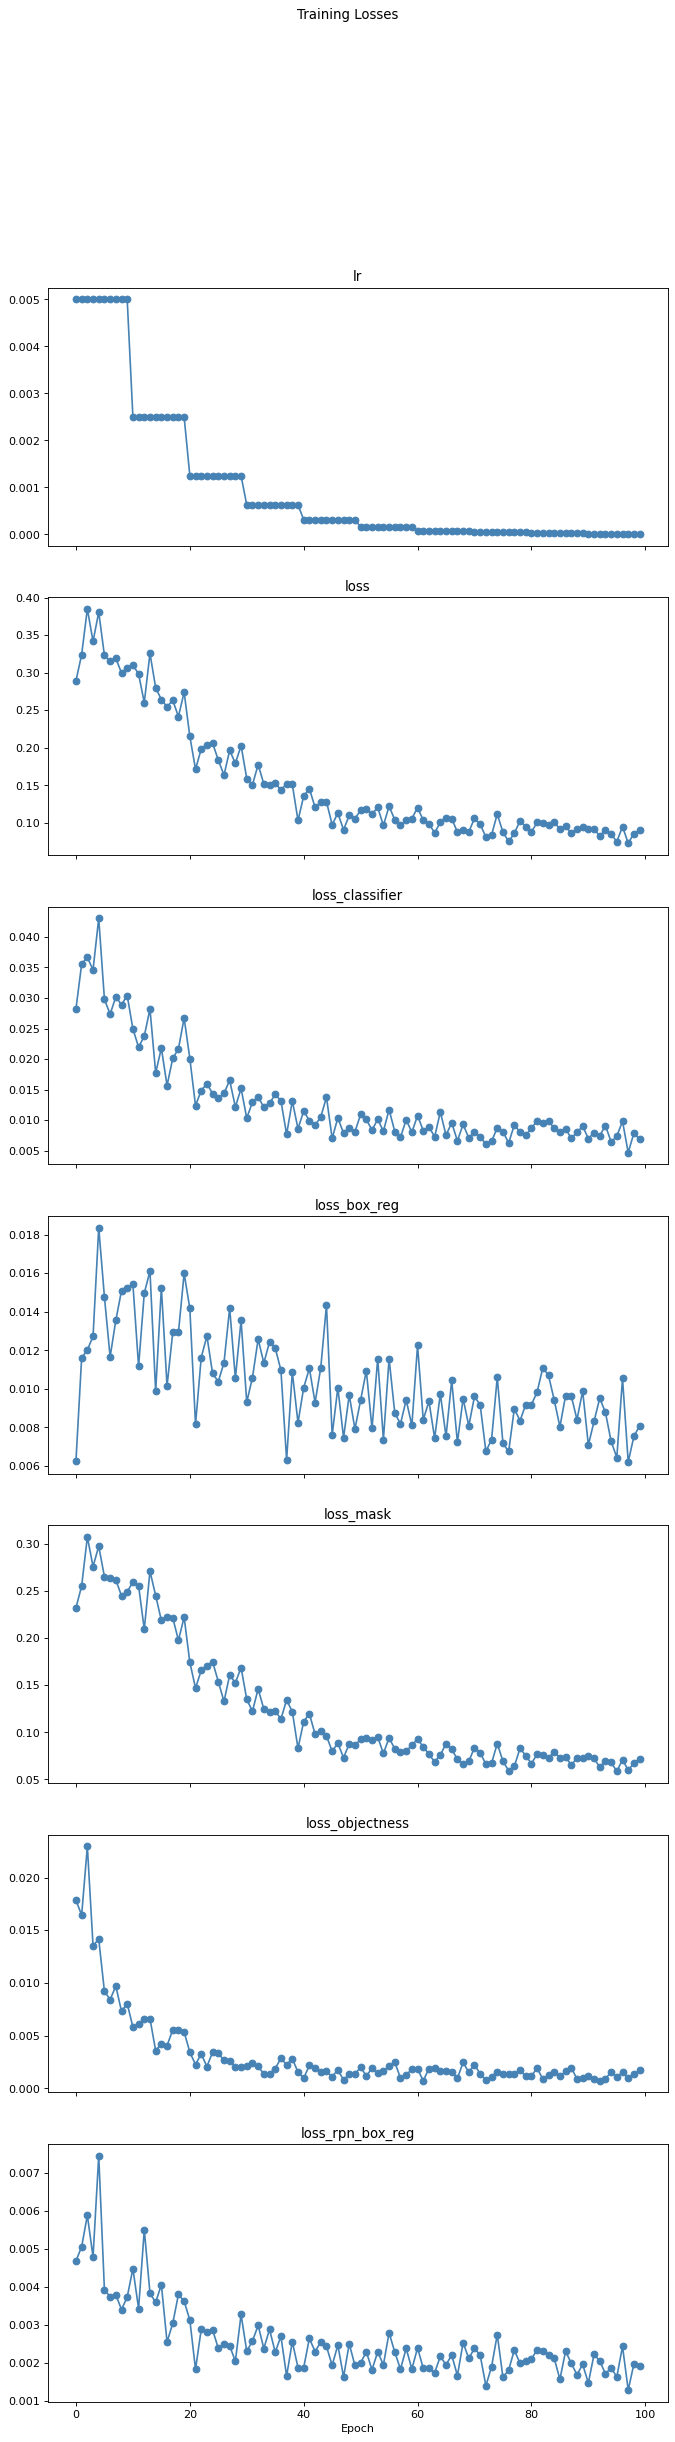

In [15]:
plot_loss(training_record['train_data'])

#### print evaluation result.

In [16]:
training_record['test_evaluator'].summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.113
IoU metric: segm
 A

## [Ajustable Section 2] Define the dicom_id you want to check. And, set the threshold for bounding boxes. 

In [17]:
dicom_id = '34cedb74-d0996b40-6d218312-a9174bea-d48dc033'

model.roi_heads.score_thresh = 0.2 # Score threshold for bounding boxes.

## Plot detections.

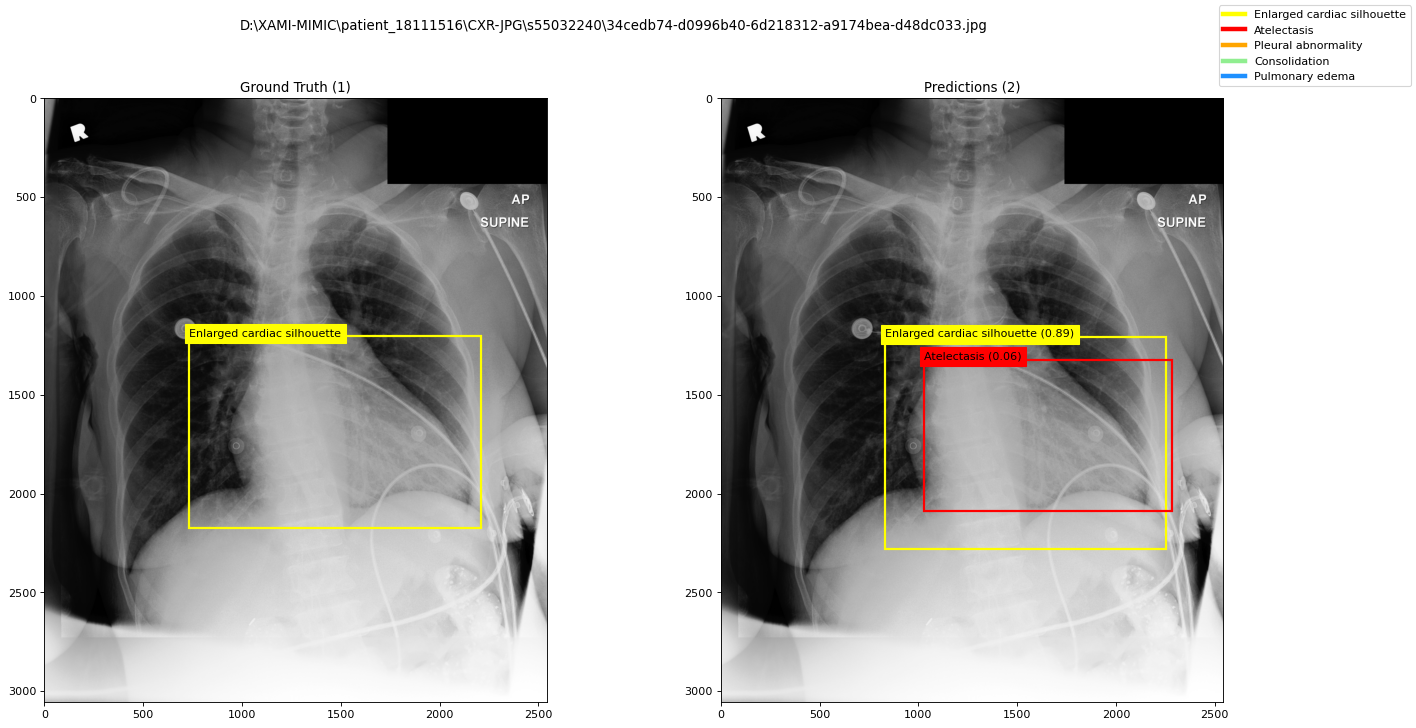

In [18]:
%matplotlib inline

idx= detect_eval_dataset.get_idxs_from_dicom_id(dicom_id)[0]

plot_result(
    model=model,
    dataset=detect_eval_dataset,
    device=device,
    idx= idx,
    legend_elements= legend_elements,
    disease_cmap =disease_cmap,
    seg=False,
    seg_thres=0.5,
)